In [57]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
import sys
sys.path.append('../')

from game_runner import NegotitaionGame
from eval.game_evaluator import GameEvaluator
import agents.simple_agent as simple_agent
import agents.llm_agent as llm_agent
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from prompts.make_prompt import make_prompt
from metrics.visualizations import (
    plot_discounted_values,
    plot_offer_evolution,
    plot_negotiation_gap,
    plot_fairness
)

pathology_results = pd.DataFrame()
#Add COLUMNS 


In [59]:
def calculate_discounted_value(offer, values, gamma, round_num):
    if offer is None:
        return 0
    base_value = sum(v * q for v, q in zip(values, offer))
    return base_value * (gamma ** (round_num - 1))


In [60]:
prompt_style = 'basic'
date = '11_11_2024'
max_rounds = 3


rounds = []
p1_values = []
p2_values = []
games = 20 #SPECIFY NUMBER OF GAMES TO RUN
#LOOP TO RUN NEGOTIATION
for i in range(games):
    rounds = []
    p1_values = []
    p2_values = []
    p1_offers = []
    p2_offers = []
    rounds = []
    p1_values = []
    p2_values = []
    
    game = NegotitaionGame(
        player1_agent=llm_agent.LLMAgent(player_num=0),
        player2_agent=llm_agent.LLMAgent(player_num=1),
        num_items=5,
        item_value_range=[1, 101],
        gamma=0.9,
        max_rounds=max_rounds,
        outside_offer_value_range=[1, 1000]
    )   
    while game.in_progress:  
        current_step = len(game.history[0]) + len(game.history[1]) + 1
        current_round = (current_step - 1) // 2 + 1 
        current_player = 1 if current_step % 2 == 1 else 2
        
        print(f"\n{'='*80}")
        print(f"Round {current_round}, Player {current_player}'s turn (Step {current_step})")
        print(f"{'='*80}")

        prev_offer = game.current_offer  
        game.step()  
        
        if game.current_offer: #NORMAL ROUNDS
            #p1_kept = game.items - np.array(game.current_offer.offer)
        # p1_value = calculate_discounted_value(p1_kept, game.player_values[0], game.gamma, current_round)
            #p2_value = calculate_discounted_value(game.current_offer.offer, game.player_values[1], game.gamma, current_round)
          
            if current_player == 1:

                p1_kept = game.items - np.array(game.current_offer.offer)
                p1_value = calculate_discounted_value(p1_kept, game.player_values[0], game.gamma, current_round)
                p2_value = calculate_discounted_value(game.current_offer.offer, game.player_values[1], game.gamma, current_round)
                rounds.append(current_round)
                p1_values.append(p1_value) #discounted value P1 would get from the current offer
                p2_values.append(p2_value) #discounted value P2 would get from the current offer
                
            if current_player == 2: #PLAYER 2 OFFERS
                rounds.append(current_round)
                p1_kept = game.items - np.array(game.current_offer.offer)
                p1_value = calculate_discounted_value(p1_kept, game.player_values[0], game.gamma, current_round)
                p2_value = calculate_discounted_value(game.current_offer.offer, game.player_values[1], game.gamma, current_round)
                p1_values.append(p1_value) #discounted value P1 would get from the current offer
                p2_values.append(p2_value) #discounted value P2 would get from the current offer
                p1_offers.append(prev_offer.offer)  
                p2_offers.append(game.current_offer.offer)
                
                print(f"\nRound {current_round} Values:")
                print(f"Player 1: {p1_value:.2f}")
                print(f"Player 2: {p2_value:.2f}")
        
        
        if current_round == game.max_rounds and current_player == 2: #IF WE ARE ON THE LAST ROUND
            if game.current_offer and game.current_offer != prev_offer: #IF PLAYER 2 MAKES A COUNTEROFFER WE TREAT IT AS WALK
                print(f"\nPlayer 2's final action: COUNTEROFFER {game.current_offer.offer}")
                p1_value = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                p2_value = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
                print("\nGame ended after max rounds - both players get outside offers")
            elif game.current_offer == prev_offer: #IF PLAYER 2 ACCEPTS
                print("\nPlayer 2's final action: ACCEPT")
                p1_kept = game.items - np.array(game.current_offer.offer)
                p1_value = calculate_discounted_value(p1_kept, game.player_values[0], game.gamma, current_round)
                p2_value = calculate_discounted_value(game.current_offer.offer, game.player_values[1], game.gamma, current_round)
            else: #IF PLAYER 2 WALKS
                print("\nPlayer 2's final action: WALK")
                p1_value = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                p2_value = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
                print("\nGame ended after max rounds - both players get outside offers")
            
            game.in_progress = False
            print(f"\nRound {current_round} Final Values:")
            print(f"Player 1: {p1_value:.2f}")
            print(f"Player 2: {p2_value:.2f}")
            
            rounds.append(current_round)
            p1_values.append(p1_value)
            p2_values.append(p2_value)
            break
    #COLLECT GAME PATHOLOGIES
    evaluator = GameEvaluator(game)
    # Process each regular move first
    player1 = []
    player2 = []
    for player in [0, 1]:
        for round_idx in range(len(game.history[player])):
            result = evaluator.check_pathologies(round_idx, i, player)
            if result is not None:
                if player == 0:
                    player1.append(result)
                else:
                    player2.append(result)

  
    print(p1_values) #odd indicies are the offers, even indicies are what they get if they accept player2's offer
    print(p2_values) #even indicies are the offers, odd indicies are what they get if they accept player1's offer

    
    #final action
    final_action = evaluator.check_final_action(i, game.final_action_player, max(len(game.history[0]), len(game.history[1])))
   
    

    #fill pathology results
    for p1, p2 in zip(player1, player2):
        pathology_results = pd.concat([pathology_results, pd.DataFrame([p1, p2])], ignore_index=True)

    #add final action
    pathology_results = pd.concat([pathology_results, pd.DataFrame([final_action])], ignore_index=True)

pathology_results.to_csv('pathology_results_basic_11_11_2024.csv', index=False)





Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 7 units of item 2, 3 units of item 3, 1 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 48 for item 1, 12 for item 2, 79 for item 3, 74 for item 4, 78 for item 5.
    Both you and Player 2 also have a private outside offer, of value drawn from a uniform random distribution, ranging from 1 to 1000.
    Your outside offer value is 845.

    The negotiation proceeds in 3 rounds.
    There is a discount rate gamma = 0.9, such that if the process concludes after r rounds the overall value of the negotiation to each player is their value fo

## Statistics of Play for Each Player Over Games

In [61]:
# Read the CSV data
df = pd.read_csv('../experiments/pathology_results_basic_11_11_2024.csv')
print(df)
# List of pathology columns
pathology_columns = [
    'accepting_an_offer_worse_than_outside_offer',
    'making_an_offer_worse_for_you_than_your_outside_offer',
    'walking_away_from_an_offer_better_than_your_outside_offer',
    'offer_no_items_or_all_items',
    'making_offer_worse_than_previous'
]

# Overall statistics
print("Overall Statistics:")
for col in pathology_columns:
    total_count = df[col].notna().sum()  # Count non-NA values
    true_count = df[col].sum()
    percentage = (true_count / total_count * 100) if total_count > 0 else 0
    print(f"{col}:")
    print(f"  Count: {true_count}")
    print(f"  Percentage: {percentage:.2f}%")
    print()



   game_num  round_num  player  discount_rate            offer   
0         1          1       1           1.00  [2, 4, 1, 0, 1]  \
1         1          1       2           1.00  [2, 3, 2, 0, 2]   
2         1          2       1           0.90  [2, 5, 1, 0, 1]   
3         1          2       2           0.90  [2, 4, 1, 0, 2]   
4         1          3       1           0.81              NaN   

              value        items your_side_of_current_offer  outside_offer   
0  [48 12 79 74 78]  [4 7 3 1 3]                [2 3 2 1 2]            845  \
1  [63 54 75  4 17]  [4 7 3 1 3]                [2 4 1 1 1]             77   
2  [48 12 79 74 78]  [4 7 3 1 3]                [2 2 2 1 2]            845   
3  [63 54 75  4 17]  [4 7 3 1 3]                [2 3 2 1 1]             77   
4  [48 12 79 74 78]  [4 7 3 1 3]                        NaN            845   

   accepting_an_offer_worse_than_outside_offer   
0                                        False  \
1                                 

## Discounted Values Over Time

For each offer/counter-offer:
- Blue line shows what Player 1 would receive from that division of items in their offer
- Red line shows what Player 2 would receive from that division of items counter offer


So each point on the graph shows the value each player would get if that particular division of items was accepted, after applying the time discount ($\gamma^{round-1}$).



In [62]:
if game.current_offer: 
    plot_discounted_values(rounds, p1_values, p2_values, max_rounds)

if game.current_offer:
    print(f"\nFinal Values:")
    print(f"Player 1: {p1_values[-1]:.2f}")
    print(f"Player 2: {p2_values[-1]:.2f}")

## Offer Evolution Plot

This visualization shows how the distribution of items changes over the negotiation rounds, with a separate subplot for each item type.

### Layout
- Creates a grid of subplots (2 columns)
- One subplot per item type
- For odd number of items, removes unused subplot

### Per Item Subplot
- X-axis: Negotiation rounds
- Y-axis: Number of units offered to P2
- Blue line (○): P1's offers
- Red line (○): P2's counter-offers
- Y-axis range: 0 to maximum units available for that item
- Grid shows valid integer unit values

### Interpretation
- Shows how many units of each item type each player offered to give to P2
- P1's remaining units = total_items - offered_units
- Converging lines suggest agreement being reached
- Diverging lines suggest areas of contention

Number of rounds: 4
Number of P1 offers: 2
Number of P2 offers: 2


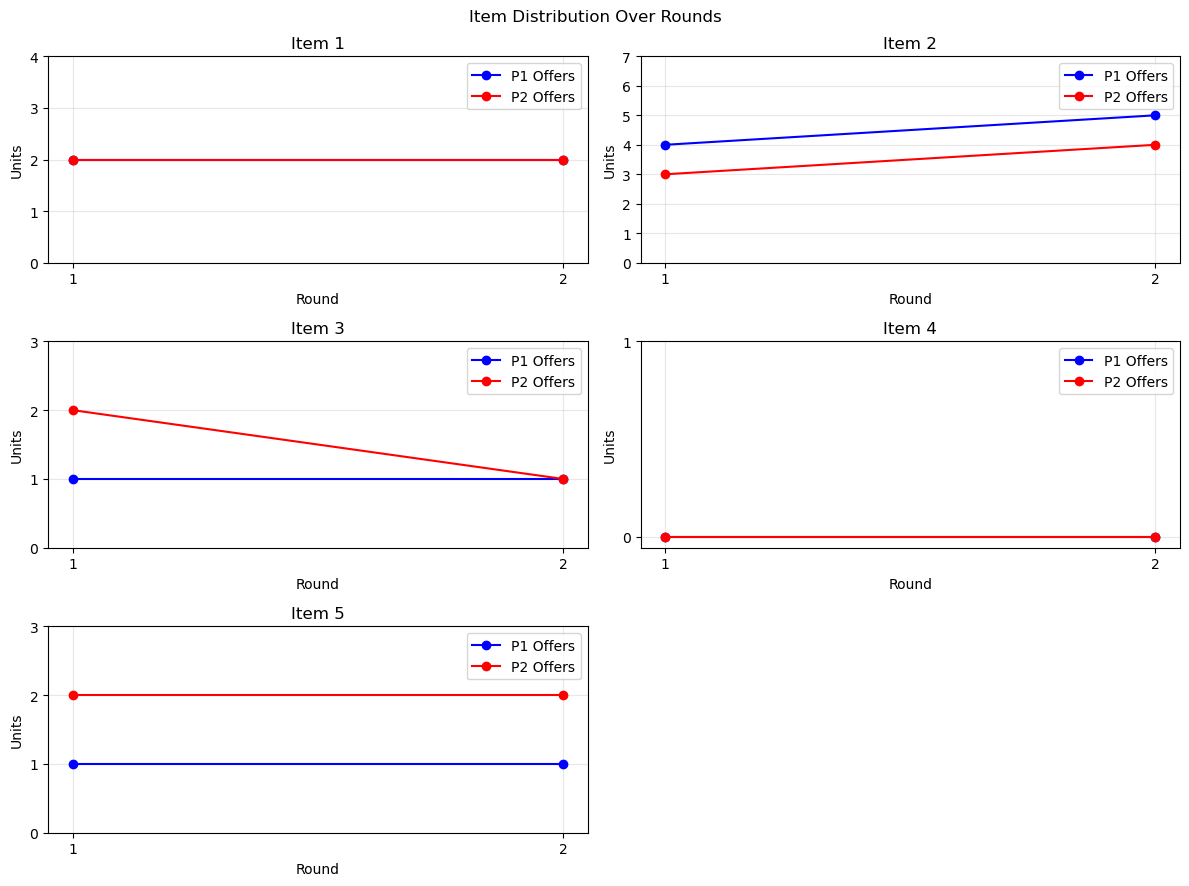

In [63]:
plot_offer_evolution(game, rounds, p1_offers, p2_offers)

In [64]:
def get_final_division(game):
    if game.current_offer: 
        p2_items = game.current_offer.offer  
        p1_items = [t - g for t, g in zip(game.items, p2_items)]  
        return {
            'P1': p1_items,
            'P2': p2_items
        }
    return None
evaluator = GameEvaluator(game)
outside_offer_rational = evaluator.evaluate_outside_offer_consistency()

if game.current_offer:
    final_division = get_final_division(game)
    value_gaps = [abs(p1 - p2) for p1, p2 in zip(p1_values, p2_values)] 
    fairness = [(p1/(p1+p2), p2/(p1+p2)) for p1, p2 in zip(p1_values, p2_values)]  

    print("\nBasic Metrics:")
    print(f"Final P1 Value: {p1_values[-1]:.2f}")
    print(f"Final P2 Value: {p2_values[-1]:.2f}")
    print(f"Final Value Gap: {value_gaps[-1]:.2f}")
    print(f"Final Fairness Ratio: {fairness[-1][0]:.2f} : {fairness[-1][1]:.2f}")
    print("\nFinal Division of Items:")
    if final_division:
        print(f"Total Items Available: {game.items}")
        print(f"P1 Received: {final_division['P1']}")
        print(f"P2 Received: {final_division['P2']}")
    else:
        print("No deal reached - no items were divided")

print("\nNegotiation Evaluation:")
print(f"Outside Offer Rational: {'Yes' if outside_offer_rational else 'No'}")

print(f"P1 Valuation of Each Item: {game.player_values[0]}")
print(f"P2 Valuation of Each Item: {game.player_values[1]}")


Negotiation Evaluation:
Outside Offer Rational: No
P1 Valuation of Each Item: [48 12 79 74 78]
P2 Valuation of Each Item: [63 54 75  4 17]


## Check Pathologies
- Check if Pathologies Occured
- Check Count in game 
- Save to csv
